# Bike Sharing Assignment
A bike-sharing system is a service in which bikes are made available for shared use to individuals on a short term basis for a price or free. Many bike share systems allow people to borrow a bike from a "dock" which is usually computer-controlled wherein the user enters the payment information, and the system unlocks it. This bike can then be returned to another dock belonging to the same system.
## Business Goal:
You are required to model the demand for shared bikes with the available independent variables. It will be used by the management to understand how exactly the demands vary with different features. They can accordingly manipulate the business strategy to meet the demand levels and meet the customer's expectations

In [349]:
# Do the necessary imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler 
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import r2_score, mean_squared_error 



# Warnings module is used to handle warnings
import warnings
warnings.filterwarnings('ignore')

In [350]:
# Display all columns of the dataframe

pd.set_option('display.max_columns', None)

In [351]:
#Read the dataset
df = pd.read_csv('day.csv')
df.head()
df.tail()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
725,726,27-12-2019,1,1,12,0,4,1,2,10.420847,11.33210,65.2917,23.458911,247,1867,2114
726,727,28-12-2019,1,1,12,0,5,1,2,10.386653,12.75230,59.0000,10.416557,644,2451,3095
727,728,29-12-2019,1,1,12,0,6,0,2,10.386653,12.12000,75.2917,8.333661,159,1182,1341
728,729,30-12-2019,1,1,12,0,0,0,1,10.489153,11.58500,48.3333,23.500518,364,1432,1796
729,730,31-12-2019,1,1,12,0,1,1,2,8.849153,11.17435,57.7500,10.374682,439,2290,2729


# Columns in the input data
     # instant: record index
	# dteday : date
	# season : season (1:spring, 2:summer, 3:fall, 4:winter)
	# yr : year (0: 2018, 1:2019)
	# mnth : month ( 1 to 12)
	# holiday : weather day is a holiday or not (extracted from http://dchr.dc.gov/page/holiday#schedule)
	# weekday : day of the week
	# workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
	# weathersit :
		# 1: Clear, Few clouds, Partly cloudy, Partly cloudy
		# 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
		# 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
		# 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
	# temp : temperature in Celsius
	# atemp: feeling temperature in Celsius
	# hum: humidity
	# windspeed: wind speed
	# casual: count of casual users
	# registered: count of registered users
	# cnt: count of total rental bikes including both casual and registered

In [353]:
#check the shape of the dataset
print(df.shape)
df.describe()

(730, 16)


,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,365.500000,2.498630,0.500000,6.526027,0.028767,2.997260,0.683562,1.394521,20.319259,23.726322,62.765175,12.763620,849.249315,3658.757534,4508.006849
std,210.877136,1.110184,0.500343,3.450215,0.167266,2.006161,0.465405,0.544807,7.506729,8.150308,14.237589,5.195841,686.479875,1559.758728,1936.011647
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.424346,3.953480,0.000000,1.500244,2.000000,20.000000,22.000000
25%,183.250000,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,13.811885,16.889713,52.000000,9.041650,316.250000,2502.250000,3169.750000
50%,365.500000,3.000000,0.500000,7.000000,0.000000,3.000000,1.000000,1.000000,20.465826,24.368225,62.625000,12.125325,717.000000,3664.500000,4548.500000
75%,547.750000,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,26.880615,30.445775,72.989575,15.625589,1096.500000,4783.250000,5966.000000
max,730.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,35.328347,42.044800,97.250000,34.000021,3410.000000,6946.000000,8714.000000


# Data Cleaning - remove columns which are not required for prediction. 
casual and registered: These columns represent the individual components of the target variable (cnt). Including them in the model might lead to multicollinearity and make it difficult to interpret the coefficients.
instant - It is an index column
dteday - Derived columns like year, holiday,weekday already exists, hence this can be dropped.

In [355]:
df.drop(['casual','registered','instant','dteday'],axis=1,inplace=True)
df

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,1600
...,...,...,...,...,...,...,...,...,...,...,...,...
725,1,1,12,0,4,1,2,10.420847,11.33210,65.2917,23.458911,2114
726,1,1,12,0,5,1,2,10.386653,12.75230,59.0000,10.416557,3095
727,1,1,12,0,6,0,2,10.386653,12.12000,75.2917,8.333661,1341
728,1,1,12,0,0,0,1,10.489153,11.58500,48.3333,23.500518,1796


# Data Understanding

## Converting feature values into categorical string values for
season <br>
yr <br>
mnth <br>
weekday<br>
weathersit<br>

In [358]:
# Create a dictionary 
mnth_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'June',7: 'July', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}
yr_map ={0: 2018, 1: 2019}
season_map = {1:'spring', 2:'summer', 3:'fall', 4:'winter'}
weekday_map={0:'Sun' ,1: 'Mon', 2: 'Tues', 3: 'Wed', 4: 'Thurs', 5: 'Fri', 6: 'Sat'}
weathersit_map={1 :'Clear', 2: 'Misty_Cloudy', 3:'Light_Rain', 4:'Heavy_Rain'}

In [359]:
df['season']=df['season'].map(season_map)
df['mnth']=df['mnth'].map(mnth_map)
df['weekday']=df['weekday'].map(weekday_map)
df['weathersit']=df['weathersit'].map(weathersit_map)
df['yr']=df['yr'].map(yr_map)
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,spring,2018,Jan,0,Sat,0,Misty_Cloudy,14.110847,18.18125,80.5833,10.749882,985
1,spring,2018,Jan,0,Sun,0,Misty_Cloudy,14.902598,17.68695,69.6087,16.652113,801
2,spring,2018,Jan,0,Mon,1,Clear,8.050924,9.47025,43.7273,16.636703,1349
3,spring,2018,Jan,0,Tues,1,Clear,8.200000,10.60610,59.0435,10.739832,1562
4,spring,2018,Jan,0,Wed,1,Clear,9.305237,11.46350,43.6957,12.522300,1600


In [360]:
df.columns

Index(['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'cnt'],
      dtype='object')

# Univariate Analysis

In [362]:
## Distribution of target variable cnt

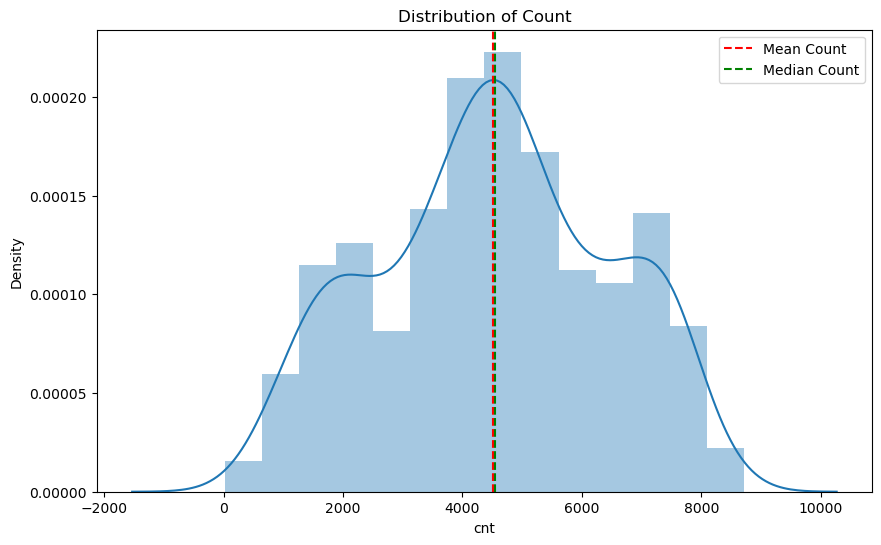

In [363]:
# Distribution of the target variable i.e. count
plt.figure(figsize=(10, 6))
sns.distplot(df['cnt'])
plt.axvline(df['cnt'].mean(), color='r', linestyle='--', label='Mean Count')
plt.axvline(df['cnt'].median(), color='g', linestyle='--', label='Median Count')
plt.legend()
plt.title('Distribution of Count')
plt.show()

In [364]:
df.cnt.skew()

-0.04958060487648213

 The skewness is between -0.5 to 0.5, the data is fairly symmetrical

### Analysis of temperature column

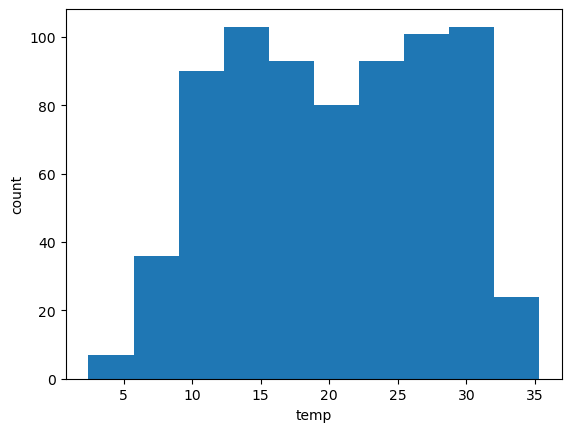

In [367]:
# temp
plt.hist(df['temp'])
plt.xlabel('temp')
plt.ylabel('count')
plt.show()

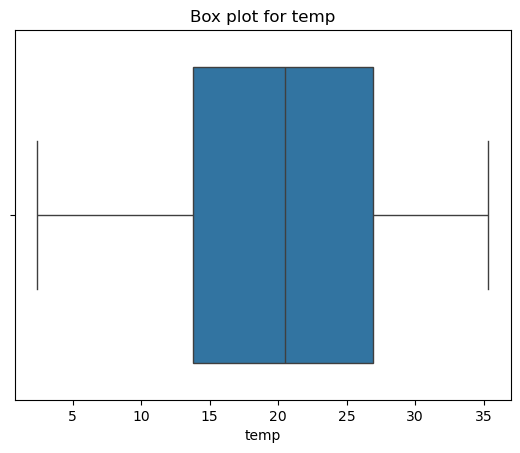

In [368]:
sns.boxplot(x='temp',data=df)
plt.title('Box plot for temp')
plt.xlabel('temp')
plt.show()

Median temperatue is 20 degree celcius
50% of the data is having temperate betweem 14 and 27 degree celcius.


### Check the value counts of categorical columns

In [371]:
#season 

print(df.season.value_counts())
print()

#Yr
print(df.yr.value_counts())
print()

#mnth 
print(df.mnth.value_counts())
print()

#weekday
print(df.weekday.value_counts())
print()

#weathersit<
print(df.weathersit.value_counts())
print()



season
fall      188
summer    184
spring    180
winter    178
Name: count, dtype: int64

yr
2018    365
2019    365
Name: count, dtype: int64

mnth
Jan     62
Mar     62
May     62
July    62
Aug     62
Oct     62
Dec     62
Apr     60
June    60
Sep     60
Nov     60
Feb     56
Name: count, dtype: int64

weekday
Sat      105
Sun      105
Mon      105
Tues     104
Thurs    104
Fri      104
Wed      103
Name: count, dtype: int64

weathersit
Clear           463
Misty_Cloudy    246
Light_Rain       21
Name: count, dtype: int64



# Bivariate Analysis

### Year vs count

In [374]:
def create_barchart(features,hue_feature=None):
	sns.barplot(data=df,x=features,y='cnt',hue=hue_feature)	
	plt.show()


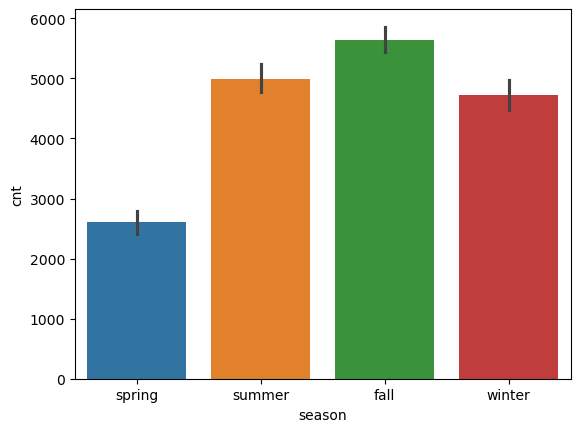

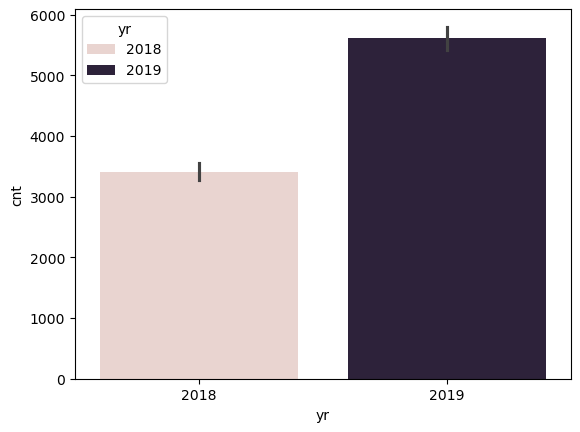

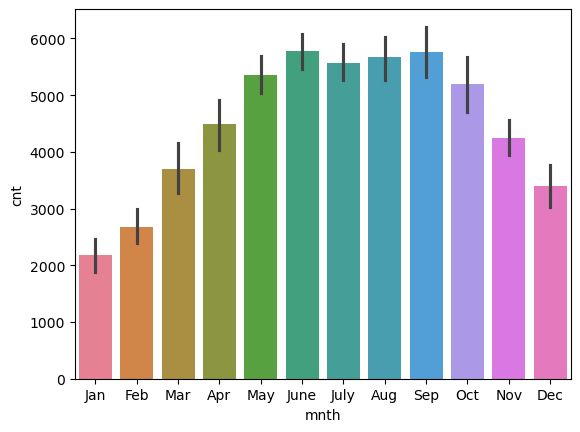

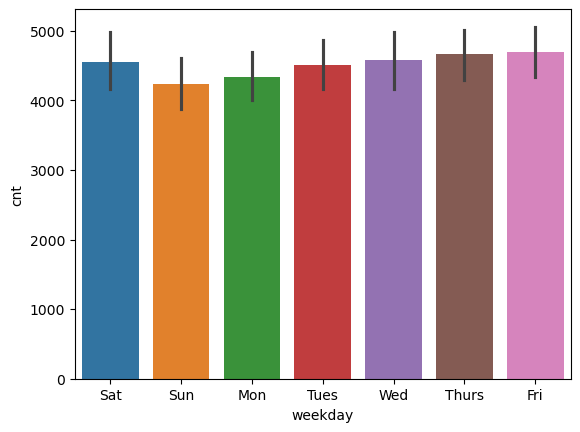

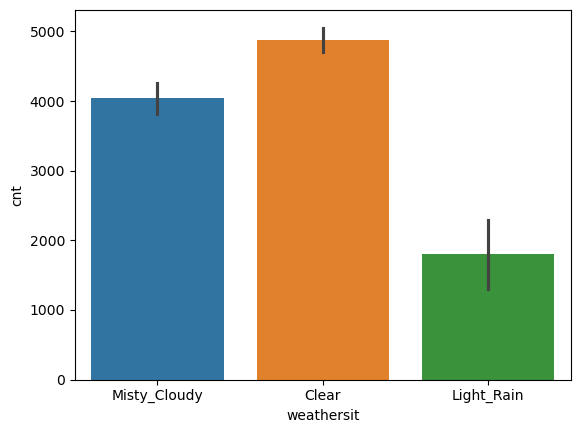

In [375]:
for feature in ['season','yr','mnth','weekday','weathersit']:
    create_barchart(feature,feature)

season: Users are booking bikes more in fall season and least in spring season. <br>
yr: Bike bookings is increasing year on year. 2019 saw more bookings compared to 2018. <br>
mnth: there is a steady increase in booking from May to Sep<br>
weekday: There is a steady increase in number of bookings from sun to sat. Maximum number of bookings is on Sat.<br>
weathersit: Users tend to book bikes more when weather is Clear. Least number of bookings seen during Light Rain.<br>



## creating a pairplot between the numerical variables

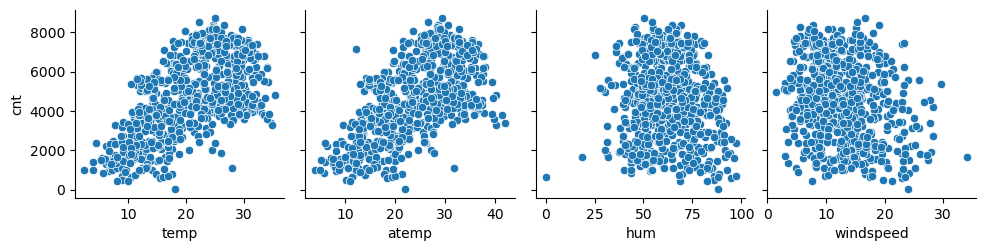

In [378]:
sns.pairplot(data=df,x_vars=['temp','atemp','hum','windspeed'],y_vars='cnt')
plt.show()

Higher temp and atemp is leading to higher bike rental counts.
There is a positive correlation between cnt and temp, also cnt and atemp.


# Data preparation for model development

### create dummies for categorical columns and remove the first column to prevent multicollinearity.

In [382]:

months_df=pd.get_dummies(df['mnth'],drop_first=True,dtype=int)
weekdays_df=pd.get_dummies(df['weekday'],drop_first=True,dtype=int)
weathersit_df=pd.get_dummies(df['weathersit'],drop_first=True,dtype=int)
seasons_df=pd.get_dummies(df['season'],drop_first=True,dtype=int)

In [383]:
months_df

,Aug,Dec,Feb,Jan,July,June,Mar,May,Nov,Oct,Sep
0,0,0,0,1,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
725,0,1,0,0,0,0,0,0,0,0,0
726,0,1,0,0,0,0,0,0,0,0,0
727,0,1,0,0,0,0,0,0,0,0,0
728,0,1,0,0,0,0,0,0,0,0,0


In [384]:
weekdays_df

,Mon,Sat,Sun,Thurs,Tues,Wed
0,0,1,0,0,0,0
1,0,0,1,0,0,0
2,1,0,0,0,0,0
3,0,0,0,0,1,0
4,0,0,0,0,0,1
...,...,...,...,...,...,...
725,0,0,0,1,0,0
726,0,0,0,0,0,0
727,0,1,0,0,0,0
728,0,0,1,0,0,0


In [385]:
weathersit_df

,Light_Rain,Misty_Cloudy
0,0,1
1,0,1
2,0,0
3,0,0
4,0,0
...,...,...
725,0,1
726,0,1
727,0,1
728,0,0


In [386]:
seasons_df

,spring,summer,winter
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0
...,...,...,...
725,1,0,0
726,1,0,0
727,1,0,0
728,1,0,0


In [387]:
# concat newly created dummy columns withe the main df 
df=pd.concat([df,months_df,seasons_df,weekdays_df,weathersit_df],axis="columns")

In [388]:
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,Aug,Dec,Feb,Jan,July,June,Mar,May,Nov,Oct,Sep,spring,summer,winter,Mon,Sat,Sun,Thurs,Tues,Wed,Light_Rain,Misty_Cloudy
0,spring,2018,Jan,0,Sat,0,Misty_Cloudy,14.110847,18.18125,80.5833,10.749882,985,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1
1,spring,2018,Jan,0,Sun,0,Misty_Cloudy,14.902598,17.68695,69.6087,16.652113,801,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1
2,spring,2018,Jan,0,Mon,1,Clear,8.050924,9.47025,43.7273,16.636703,1349,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0
3,spring,2018,Jan,0,Tues,1,Clear,8.200000,10.60610,59.0435,10.739832,1562,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
4,spring,2018,Jan,0,Wed,1,Clear,9.305237,11.46350,43.6957,12.522300,1600,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0


Dropping the source columns used for creating dummy columns

In [390]:
df.drop(['mnth','weekday','weathersit','season'],inplace=True,axis='columns')

In [391]:
df.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,Aug,Dec,Feb,Jan,July,June,Mar,May,Nov,Oct,Sep,spring,summer,winter,Mon,Sat,Sun,Thurs,Tues,Wed,Light_Rain,Misty_Cloudy
0,2018,0,0,14.110847,18.18125,80.5833,10.749882,985,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1
1,2018,0,0,14.902598,17.68695,69.6087,16.652113,801,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1
2,2018,0,1,8.050924,9.47025,43.7273,16.636703,1349,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0
3,2018,0,1,8.200000,10.60610,59.0435,10.739832,1562,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
4,2018,0,1,9.305237,11.46350,43.6957,12.522300,1600,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0


converting year to 0 and 1 ( 2018 - 0, 2019 - 1)

In [393]:
df['yr'] = (df['yr'] == 2019).astype(int)

Creating a correlation matrix

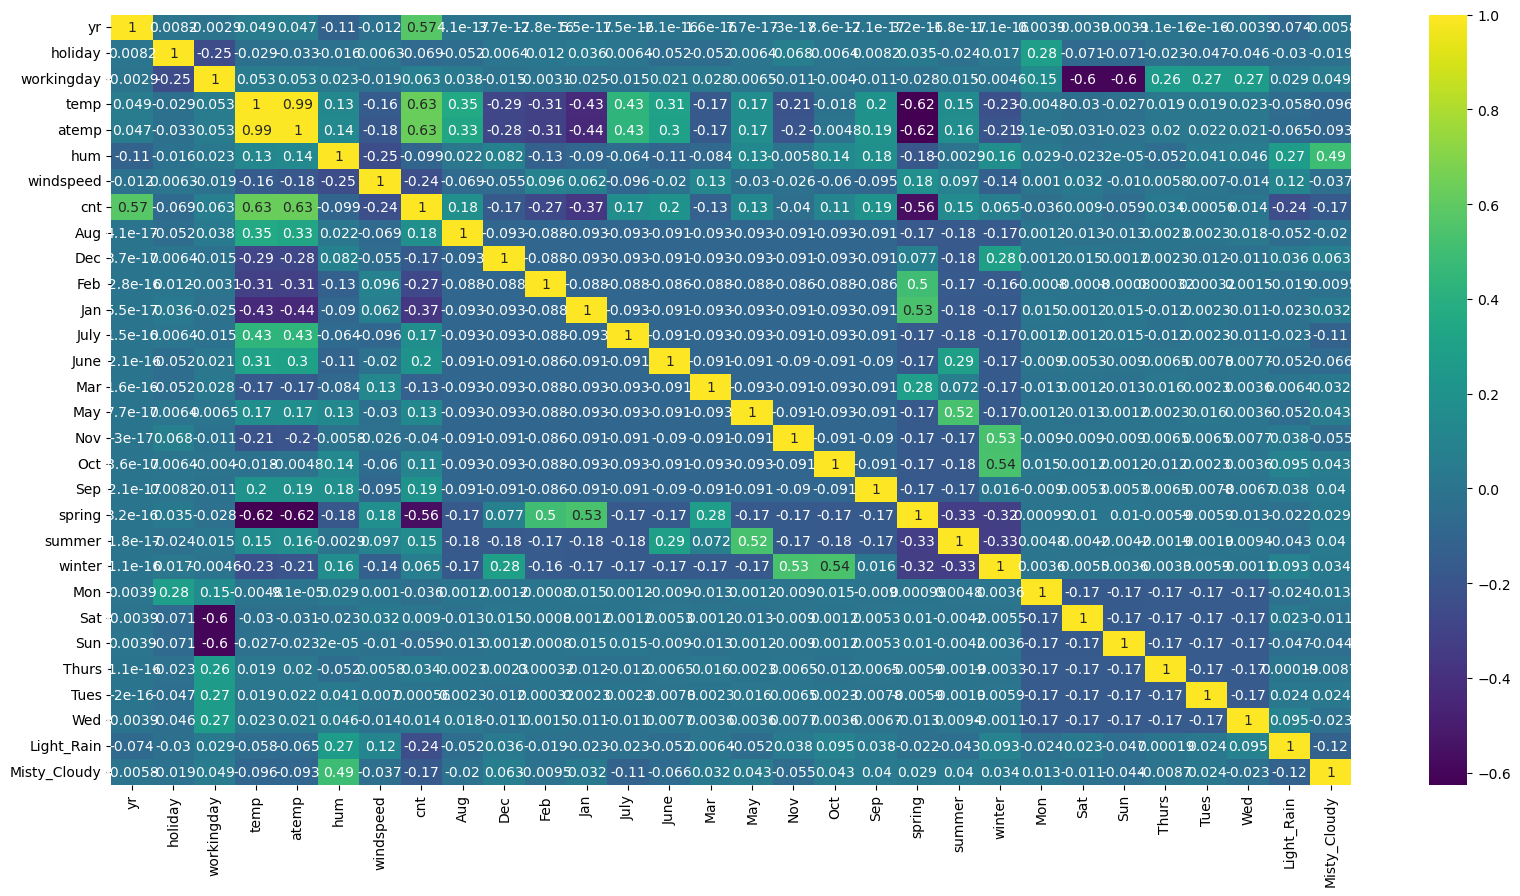

In [395]:
plt.figure(figsize=(20,10))
sns.heatmap(df.corr(),annot=True,cmap='viridis')
plt.show()

In [396]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 30 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   yr            730 non-null    int32  
 1   holiday       730 non-null    int64  
 2   workingday    730 non-null    int64  
 3   temp          730 non-null    float64
 4   atemp         730 non-null    float64
 5   hum           730 non-null    float64
 6   windspeed     730 non-null    float64
 7   cnt           730 non-null    int64  
 8   Aug           730 non-null    int32  
 9   Dec           730 non-null    int32  
 10  Feb           730 non-null    int32  
 11  Jan           730 non-null    int32  
 12  July          730 non-null    int32  
 13  June          730 non-null    int32  
 14  Mar           730 non-null    int32  
 15  May           730 non-null    int32  
 16  Nov           730 non-null    int32  
 17  Oct           730 non-null    int32  
 18  Sep           730 non-null    

## Model Development

Split dataset into train and test datasets

In [399]:
from sklearn.model_selection import train_test_split 
df_train, df_test = train_test_split(df,train_size=0.7,random_state=100)


In [400]:
print('Training data: ',df_train.shape)
print('Test data: ',df_test.shape)

Training data:  (510, 30)
Test data:  (220, 30)


### Scaling the feature columns to normalize the values

In [402]:
#applying scaler() to all column except the yes-no an ddummy variables. 

scaler=MinMaxScaler()
num_vars = ['temp','atemp','windspeed','hum','cnt']
print("Before scaling: ",df_train[num_vars])
df_train[num_vars]=scaler.fit_transform(df_train[num_vars])
print("After scaling:",df_train[num_vars])
df_train.describe()


Before scaling:            temp     atemp  windspeed      hum   cnt
576  29.246653  33.14480  11.083475  70.4167  7216
426  16.980847  20.67460  10.792293  62.1250  4066
728  10.489153  11.58500  23.500518  48.3333  1796
482  15.443347  18.87520   8.708325  48.9583  4220
111  13.803347  16.09770  14.707907  72.9583  1683
..         ...       ...        ...      ...   ...
578  30.852500  35.35440   8.666718  65.9583  7261
53    9.091299  12.28585   6.305571  42.3043  1917
350  10.591653  12.46855  16.292189  56.0833  2739
79   17.647835  20.48675  19.348461  73.7391  2077
520  22.174153  26.29460  14.041525  61.3333  7001

[510 rows x 5 columns]
After scaling:          temp     atemp  windspeed       hum       cnt
576  0.815169  0.766351   0.264686  0.725633  0.827658
426  0.442393  0.438975   0.255342  0.640189  0.465255
728  0.245101  0.200348   0.663106  0.498067  0.204096
482  0.395666  0.391735   0.188475  0.504508  0.482973
111  0.345824  0.318819   0.380981  0.751824  0.191095
..

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,Aug,Dec,Feb,Jan,July,June,Mar,May,Nov,Oct,Sep,spring,summer,winter,Mon,Sat,Sun,Thurs,Tues,Wed,Light_Rain,Misty_Cloudy
count,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000
mean,0.507843,0.025490,0.676471,0.537440,0.513156,0.650480,0.320883,0.513499,0.096078,0.084314,0.066667,0.088235,0.076471,0.076471,0.098039,0.084314,0.086275,0.084314,0.080392,0.243137,0.247059,0.247059,0.150980,0.154902,0.143137,0.133333,0.131373,0.158824,0.029412,0.345098
std,0.500429,0.157763,0.468282,0.225858,0.212410,0.145846,0.169803,0.224421,0.294988,0.278131,0.249689,0.283915,0.266010,0.266010,0.297660,0.278131,0.281045,0.278131,0.272166,0.429398,0.431725,0.431725,0.358381,0.362166,0.350557,0.340268,0.338139,0.365870,0.169124,0.475867
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.339853,0.332086,0.538643,0.199179,0.356420,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,1.000000,0.542596,0.529718,0.653714,0.296763,0.518638,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,0.735215,0.688457,0.754830,0.414447,0.684710,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [403]:
#generating x_train and y_train
y_train=df_train.pop('cnt')
X_train=df_train

In [404]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 510 entries, 576 to 520
Data columns (total 29 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   yr            510 non-null    int32  
 1   holiday       510 non-null    int64  
 2   workingday    510 non-null    int64  
 3   temp          510 non-null    float64
 4   atemp         510 non-null    float64
 5   hum           510 non-null    float64
 6   windspeed     510 non-null    float64
 7   Aug           510 non-null    int32  
 8   Dec           510 non-null    int32  
 9   Feb           510 non-null    int32  
 10  Jan           510 non-null    int32  
 11  July          510 non-null    int32  
 12  June          510 non-null    int32  
 13  Mar           510 non-null    int32  
 14  May           510 non-null    int32  
 15  Nov           510 non-null    int32  
 16  Oct           510 non-null    int32  
 17  Sep           510 non-null    int32  
 18  spring        510 non-null    int

In [405]:
#building Linear Regression model using Sklearn library
model=LinearRegression()
model.fit(X_train,y_train)

LinearRegression()

In [406]:

df_train.nunique()

yr                2
holiday           2
workingday        2
temp            386
atemp           491
hum             444
windspeed       467
Aug               2
Dec               2
Feb               2
Jan               2
July              2
June              2
Mar               2
May               2
Nov               2
Oct               2
Sep               2
spring            2
summer            2
winter            2
Mon               2
Sat               2
Sun               2
Thurs             2
Tues              2
Wed               2
Light_Rain        2
Misty_Cloudy      2
dtype: int64

## Use RFE to select rigt features for the model

In [408]:
rfe = RFE(model, n_features_to_select=14)  # Adjust the number as needed
rfe.fit(X_train, y_train)
# check column details after RFE 
list(zip(X_train.columns,rfe.support_,rfe.ranking_))



[('yr', True, 1),
 ('holiday', True, 1),
 ('workingday', True, 1),
 ('temp', True, 1),
 ('atemp', False, 6),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('Aug', False, 8),
 ('Dec', False, 4),
 ('Feb', False, 5),
 ('Jan', False, 2),
 ('July', True, 1),
 ('June', False, 15),
 ('Mar', False, 16),
 ('May', False, 7),
 ('Nov', False, 3),
 ('Oct', False, 14),
 ('Sep', True, 1),
 ('spring', True, 1),
 ('summer', True, 1),
 ('winter', True, 1),
 ('Mon', False, 10),
 ('Sat', True, 1),
 ('Sun', False, 9),
 ('Thurs', False, 12),
 ('Tues', False, 11),
 ('Wed', False, 13),
 ('Light_Rain', True, 1),
 ('Misty_Cloudy', True, 1)]

## Check the selected and dropped columns

In [410]:
rfe_selected_features = X_train.columns[rfe.support_]
print("selected columns: ",rfe_selected_features)

# Get dropped features
dropped_features = X_train.columns[~rfe.support_]
print("Dropped columns: ",dropped_features)



selected columns:  Index(['yr', 'holiday', 'workingday', 'temp', 'hum', 'windspeed', 'July',
       'Sep', 'spring', 'summer', 'winter', 'Sat', 'Light_Rain',
       'Misty_Cloudy'],
      dtype='object')
Dropped columns:  Index(['atemp', 'Aug', 'Dec', 'Feb', 'Jan', 'June', 'Mar', 'May', 'Nov', 'Oct',
       'Mon', 'Sun', 'Thurs', 'Tues', 'Wed'],
      dtype='object')


### selecting RFE selected columns and adding constant to the dataframe. 


In [412]:
X_train_rfe = X_train[rfe_selected_features]
X_train_m1 = sm.add_constant(X_train_rfe)

X_train_m1.describe()

,const,yr,holiday,workingday,temp,hum,windspeed,July,Sep,spring,summer,winter,Sat,Light_Rain,Misty_Cloudy
count,510.0,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000
mean,1.0,0.507843,0.025490,0.676471,0.537440,0.650480,0.320883,0.076471,0.080392,0.243137,0.247059,0.247059,0.154902,0.029412,0.345098
std,0.0,0.500429,0.157763,0.468282,0.225858,0.145846,0.169803,0.266010,0.272166,0.429398,0.431725,0.431725,0.362166,0.169124,0.475867
min,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.0,0.000000,0.000000,0.000000,0.339853,0.538643,0.199179,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.0,1.000000,0.000000,1.000000,0.542596,0.653714,0.296763,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.0,1.000000,0.000000,1.000000,0.735215,0.754830,0.414447,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### A function for computing VIF for all features in a dataframe. 

In [414]:
# creating a function to calculate vif.
def calculate_vif(X_train):
	#create empty data frame 
    vif = pd.DataFrame()
    
	#Add feature names 
    vif['features'] = X_train.columns
    
	#compute VIF for each feature and store it in dataframe. 
    vif['Vif']  = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
    vif = vif.sort_values(by="Vif",ascending=False)
    
    return vif

### Linear Regression Model 1

In [416]:
# Using statsmodel library for building the model and validating the model 
lr_model1=sm.OLS(y_train,X_train_m1).fit()
lr_model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     195.7
Date:                Tue, 01 Oct 2024   Prob (F-statistic):          2.11e-191
Time:                        00:36:32   Log-Likelihood:                 517.61
No. Observations:                 510   AIC:                            -1005.
Df Residuals:                     495   BIC:                            -941.7
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.2402      0.036      6.714      0.000       0.170       0.310
yr               0.2298      0.008     28.647      0.000       0.214       0.246
holiday         -0.0591      0.027     -2.192      0.029      -0.112      -0.006
workingday       0.0430      0.012      3.725      0.000       0.020       0.066
temp             0.5277      0.033     15.884      0.000       0.462       0.593
hum             -0.1611      0.037     -4.313      0.000      -0.234      -0.088
windspeed       -0.1809      0.025     -7.118      0.000      -0.231      -0.131
July            -0.0546      0.018     -3.019      0.003      -0.090      -0.019
Sep              0.0820      0.017      4.966      0.000       0.050       0.114
spring          -0.0555      0.021     -2.698      0.007      -0.096      -0.015
summer           0.0537      0.015      3.631      0.000       0.025       0.083
winter           0.0992      0.017      5.815      0.000       0.066       0.133
Sat              0.0530      0.015      3.648      0.000       0.024       0.082
Light_Rain      -0.2450      0.026     -9.395      0.000      -0.296      -0.194
Misty_Cloudy    -0.0563      0.010     -5.425      0.000      -0.077      -0.036
==============================================================================
Omnibus:                       64.769   Durbin-Watson:                   2.074
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              156.630
Skew:                          -0.663   Prob(JB):                     9.73e-35
Kurtosis:                       5.369   Cond. No.                         21.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [417]:
#find VIF score 
calculate_vif(X_train_rfe)

,features,Vif
4,hum,28.459851
3,temp,16.980902
2,workingday,5.284558
5,windspeed,4.717715
8,spring,4.237846
10,winter,3.423527
9,summer,2.846663
13,Misty_Cloudy,2.285490
0,yr,2.080059
11,Sat,1.968255


Removing hum feature as it's vif is large

In [419]:
X_train_rfe.drop("hum",inplace=True,axis='columns')


In [420]:
X_train_rfe.describe()

,yr,holiday,workingday,temp,windspeed,July,Sep,spring,summer,winter,Sat,Light_Rain,Misty_Cloudy
count,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000
mean,0.507843,0.025490,0.676471,0.537440,0.320883,0.076471,0.080392,0.243137,0.247059,0.247059,0.154902,0.029412,0.345098
std,0.500429,0.157763,0.468282,0.225858,0.169803,0.266010,0.272166,0.429398,0.431725,0.431725,0.362166,0.169124,0.475867
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.339853,0.199179,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,1.000000,0.542596,0.296763,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,0.735215,0.414447,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Linear Regression model 2

In [422]:
X_train_m2 = sm.add_constant(X_train_rfe)

lr_model2=sm.OLS(y_train,X_train_m2).fit()
lr_model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.841
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     202.2
Date:                Tue, 01 Oct 2024   Prob (F-statistic):          1.28e-188
Time:                        00:36:33   Log-Likelihood:                 508.20
No. Observations:                 510   AIC:                            -988.4
Df Residuals:                     496   BIC:                            -929.1
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.1576      0.031      5.126      0.000       0.097       0.218
yr               0.2337      0.008     28.828      0.000       0.218       0.250
holiday         -0.0567      0.027     -2.069      0.039      -0.111      -0.003
workingday       0.0461      0.012      3.931      0.000       0.023       0.069
temp             0.4915      0.033     15.027      0.000       0.427       0.556
windspeed       -0.1491      0.025     -6.024      0.000      -0.198      -0.100
July            -0.0496      0.018     -2.702      0.007      -0.086      -0.014
Sep              0.0759      0.017      4.537      0.000       0.043       0.109
spring          -0.0655      0.021     -3.147      0.002      -0.106      -0.025
summer           0.0477      0.015      3.180      0.002       0.018       0.077
winter           0.0846      0.017      4.971      0.000       0.051       0.118
Sat              0.0579      0.015      3.924      0.000       0.029       0.087
Light_Rain      -0.2895      0.024    -11.880      0.000      -0.337      -0.242
Misty_Cloudy    -0.0822      0.009     -9.514      0.000      -0.099      -0.065
==============================================================================
Omnibus:                       66.828   Durbin-Watson:                   2.069
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              162.148
Skew:                          -0.682   Prob(JB):                     6.17e-36
Kurtosis:                       5.402   Cond. No.                         19.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [423]:
# calculating the vif score for features.

calculate_vif(X_train_rfe)

,features,Vif
3,temp,6.965908
2,workingday,5.204270
4,windspeed,4.654082
7,spring,2.487497
8,summer,2.335299
0,yr,2.069743
9,winter,1.977259
10,Sat,1.957518
5,July,1.584667
12,Misty_Cloudy,1.569983


In [470]:
# removing workingday  due to high Vif score 
X_train_rfe.drop("workingday",inplace=True,axis='columns')


## Linear Regression model 3

In [472]:
X_train_m3 = sm.add_constant(X_train_rfe)

lr_model3=sm.OLS(y_train,X_train_m3).fit()
lr_model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     211.6
Date:                Tue, 01 Oct 2024   Prob (F-statistic):          1.68e-186
Time:                        00:37:19   Log-Likelihood:                 500.38
No. Observations:                 510   AIC:                            -974.8
Df Residuals:                     497   BIC:                            -919.7
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.1960      0.030      6.628      0.000       0.138       0.254
yr               0.2340      0.008     28.451      0.000       0.218       0.250
holiday         -0.0941      0.026     -3.605      0.000      -0.145      -0.043
temp             0.4924      0.033     14.839      0.000       0.427       0.558
windspeed       -0.1500      0.025     -5.974      0.000      -0.199      -0.101
July            -0.0525      0.019     -2.820      0.005      -0.089      -0.016
Sep              0.0766      0.017      4.515      0.000       0.043       0.110
spring          -0.0670      0.021     -3.174      0.002      -0.108      -0.026
summer           0.0468      0.015      3.078      0.002       0.017       0.077
winter           0.0816      0.017      4.733      0.000       0.048       0.115
Sat              0.0199      0.011      1.761      0.079      -0.002       0.042
Light_Rain      -0.2846      0.025    -11.529      0.000      -0.333      -0.236
Misty_Cloudy    -0.0803      0.009     -9.176      0.000      -0.097      -0.063
==============================================================================
Omnibus:                       65.293   Durbin-Watson:                   2.051
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              140.851
Skew:                          -0.706   Prob(JB):                     2.60e-31
Kurtosis:                       5.152   Cond. No.                         17.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [474]:
calculate_vif(X_train_rfe)

,features,Vif
2,temp,5.119071
3,windspeed,4.621926
7,summer,2.229589
6,spring,2.095985
0,yr,2.068370
8,winter,1.794332
4,July,1.584625
11,Misty_Cloudy,1.552447
5,Sep,1.337455
9,Sat,1.190957


In [476]:
# removing Sat  due to high p value 
X_train_rfe.drop("Sat",inplace=True,axis='columns')

## Linear Regression model 4

In [478]:
X_train_m4 = sm.add_constant(X_train_rfe)

lr_model4=sm.OLS(y_train,X_train_m4).fit()
lr_model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     229.6
Date:                Tue, 01 Oct 2024   Prob (F-statistic):          5.06e-187
Time:                        00:39:53   Log-Likelihood:                 498.80
No. Observations:                 510   AIC:                            -973.6
Df Residuals:                     498   BIC:                            -922.8
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.1994      0.030      6.746      0.000       0.141       0.258
yr               0.2336      0.008     28.352      0.000       0.217       0.250
holiday         -0.0975      0.026     -3.736      0.000      -0.149      -0.046
temp             0.4910      0.033     14.770      0.000       0.426       0.556
windspeed       -0.1479      0.025     -5.887      0.000      -0.197      -0.099
July            -0.0521      0.019     -2.790      0.005      -0.089      -0.015
Sep              0.0768      0.017      4.517      0.000       0.043       0.110
spring          -0.0672      0.021     -3.175      0.002      -0.109      -0.026
summer           0.0465      0.015      3.051      0.002       0.017       0.076
winter           0.0817      0.017      4.730      0.000       0.048       0.116
Light_Rain      -0.2842      0.025    -11.487      0.000      -0.333      -0.236
Misty_Cloudy    -0.0802      0.009     -9.146      0.000      -0.097      -0.063
==============================================================================
Omnibus:                       59.182   Durbin-Watson:                   2.051
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              134.016
Skew:                          -0.629   Prob(JB):                     7.92e-30
Kurtosis:                       5.173   Cond. No.                         17.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [480]:
# calculating the vif score for features.
calculate_vif(X_train_rfe)

,features,Vif
2,temp,5.091960
3,windspeed,4.600677
7,summer,2.226926
6,spring,2.078996
0,yr,2.067001
8,winter,1.780437
4,July,1.583937
10,Misty_Cloudy,1.551976
5,Sep,1.336854
9,Light_Rain,1.081377


<b> This is the final model

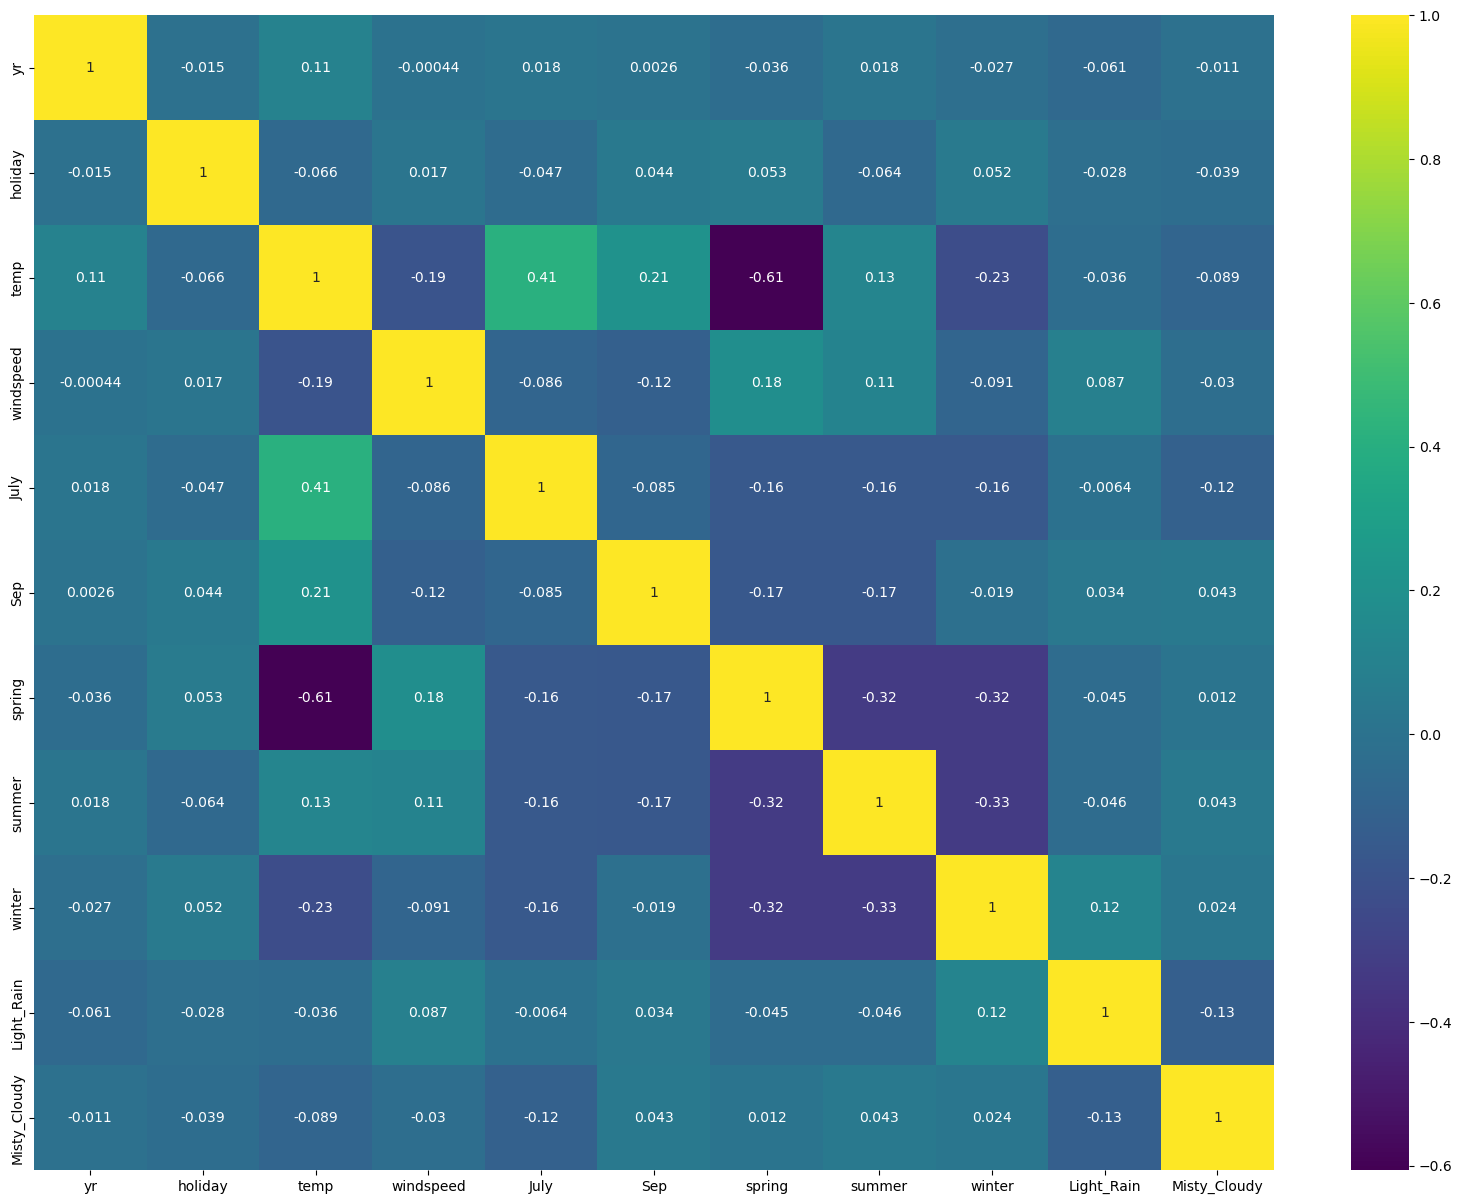

In [482]:
# heatmap for the final model dataframe.
plt.figure(figsize=(20,15))
sns.heatmap(X_train_rfe.corr(),annot=True,cmap='viridis')
plt.show()

# Residual analysis

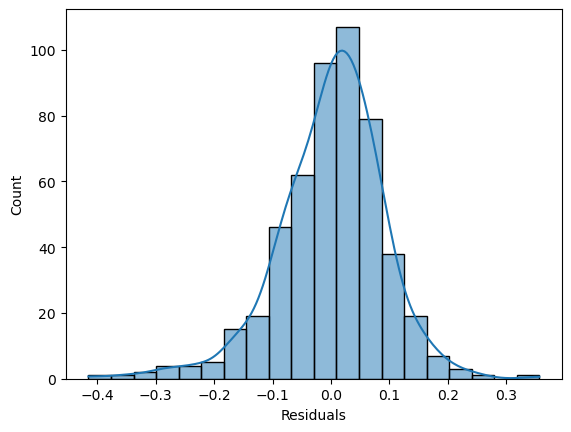

In [528]:
# add constant to final features 
X_train_final = sm.add_constant(X_train_rfe)

# Predict Y 
y_train_pred = lr_model4.predict(X_train_final)


# Check the errors 
sns.histplot(x=(y_train - y_train_pred),bins=20,kde=True)
plt.xlabel("Residuals")

plt.show()

In the above plot, we can see the normal distribution of error terms along with the mean of 0. 

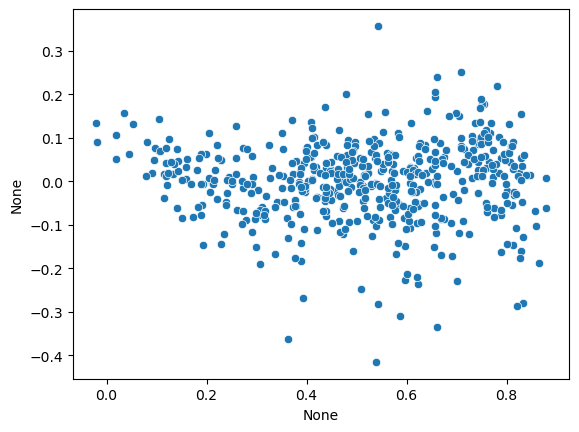

count    510.000000
mean       0.513499
std        0.224421
min        0.000000
25%        0.356420
50%        0.518638
75%        0.684710
max        1.000000
Name: cnt, dtype: float64

In [532]:
# Homoscedasticity check (There should be no visible pattern in residual values.)
sns.scatterplot(x=y_train_pred,y=(y_train - y_train_pred))
plt.show()



In [488]:
# scaling the test data with train data scaler.

df_test[num_vars] = scaler.transform(df_test[num_vars])
df_test.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,Aug,Dec,Feb,Jan,July,June,Mar,May,Nov,Oct,Sep,spring,summer,winter,Mon,Sat,Sun,Thurs,Tues,Wed,Light_Rain,Misty_Cloudy
184,0,1,0,0.831783,0.769660,0.657364,0.084219,0.692706,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
535,1,0,1,0.901354,0.842587,0.610133,0.153728,0.712034,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
299,0,0,1,0.511964,0.496145,0.837699,0.334206,0.303382,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1
221,0,0,1,0.881625,0.795343,0.437098,0.339570,0.547400,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
152,0,0,1,0.817246,0.741471,0.314298,0.537414,0.569029,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0


In [490]:
df_test.describe()


,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,Aug,Dec,Feb,Jan,July,June,Mar,May,Nov,Oct,Sep,spring,summer,winter,Mon,Sat,Sun,Thurs,Tues,Wed,Light_Rain,Misty_Cloudy
count,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000
mean,0.481818,0.036364,0.700000,0.558718,0.532847,0.638221,0.313293,0.522154,0.059091,0.086364,0.100000,0.077273,0.104545,0.095455,0.054545,0.086364,0.072727,0.086364,0.086364,0.254545,0.263636,0.236364,0.127273,0.118182,0.145455,0.163636,0.168182,0.100000,0.027273,0.318182
std,0.500809,0.187620,0.459303,0.233187,0.217401,0.148694,0.159584,0.219163,0.236333,0.281541,0.300684,0.267633,0.306665,0.294512,0.227609,0.281541,0.260281,0.281541,0.281541,0.436599,0.441609,0.425817,0.334038,0.323559,0.353363,0.370789,0.374881,0.300684,0.163248,0.466833
min,0.000000,0.000000,0.000000,0.046591,0.025950,0.261915,-0.042808,0.048205,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.355429,0.344870,0.529197,0.198843,0.378595,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,0.558172,0.544652,0.625590,0.300126,0.524678,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,0.755981,0.713308,0.743798,0.402718,0.677750,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,0.984424,0.980934,1.002146,0.807474,0.963300,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [492]:
# split the data into dependent and independent features. 
y_test = df_test.pop("cnt")
X_test = df_test

In [494]:
# creating X_test_rfe with final model features and removing all the other features.
col1 = X_train_rfe.columns
X_test_rfe = X_test[col1]
X_test_rfe = sm.add_constant(X_test_rfe)
X_test_rfe.head()

,const,yr,holiday,temp,windspeed,July,Sep,spring,summer,winter,Light_Rain,Misty_Cloudy
184,1.0,0,1,0.831783,0.084219,1,0,0,0,0,0,1
535,1.0,1,0,0.901354,0.153728,0,0,0,1,0,0,0
299,1.0,0,0,0.511964,0.334206,0,0,0,0,1,0,1
221,1.0,0,0,0.881625,0.339570,0,0,0,0,0,0,0
152,1.0,0,0,0.817246,0.537414,0,0,0,1,0,0,0


In [496]:
# Predict Y test 
y_test_pred = lr_model4.predict(X_test_rfe)

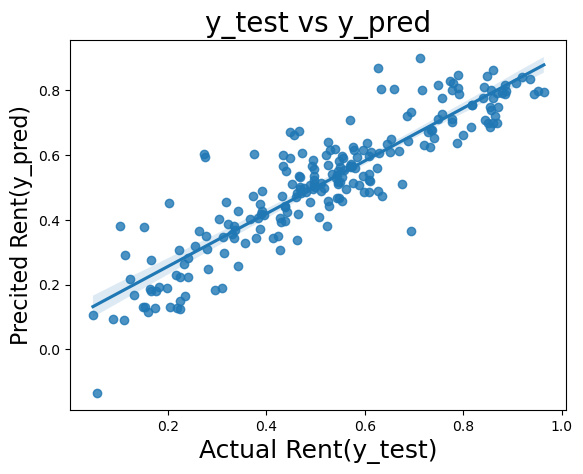

In [512]:
sns.regplot(x=(y_test),y=(y_test_pred),fit_reg=True)
plt.title('y_test vs y_pred', fontsize=20)
plt.xlabel('Actual Rent(y_test)', fontsize=18)
plt.ylabel('Precited Rent(y_pred)', fontsize=16)
plt.show()

In [502]:
# calculating the r2 score for both training dataset and testing dataset 
print('Train r2: ',r2_score(y_true=y_train,y_pred=y_train_pred))
print('Test r2: ',r2_score(y_true=y_test,y_pred=y_test_pred))

Train r2:  0.835281973840364
Test r2:  0.8052680349048552


In [504]:
# checking the mean squared error for both training and testing dataset.
print('Train mean squared error: ',mean_squared_error(y_true=y_train,y_pred=y_train_pred))
print('Test mean squared error: ',mean_squared_error(y_true=y_test,y_pred=y_test_pred))

Train mean squared error:  0.00827971071891712
Test mean squared error:  0.009310968608097095


In [510]:
lr_model4.params


const           0.199434
yr              0.233570
holiday        -0.097463
temp            0.490988
windspeed      -0.147919
July           -0.052057
Sep             0.076846
spring         -0.067169
summer          0.046487
winter          0.081741
Light_Rain     -0.284199
Misty_Cloudy   -0.080167
dtype: float64

# conclusion
## Linear regression expression
cnt = 0.199434 + 0.233570 * yr - 0.097463 * holiday + 0.490988 * temp - 0.147919 * windspeed - 0.052057 * July + 0.076846 * Sep - 0.067169 * spring + 0.046487 * summer + 0.081741 * winter - 0.284199 * Light_Rain - 0.080167 * Misty_Cloudy


Bike rental demand depends on year, holiday, temp, windspeed, sep, Light_snowrain, Misty, spring, summer and winter.
